In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,Dropout
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tensorflow.keras.callbacks import EarlyStopping

plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams.update({'font.size':20})
plt.rcParams["figure.figsize"] = (12,10)

In [2]:
str_files = ''
#Carrega os dados do arquivo .csv
ugrhi06 = pd.read_csv(str_files + "cetesb_concatenado06semoutliers.csv",encoding='utf-8',sep=',')

#Carrega os dados do arquivo .csv
ugrhi10 = pd.read_csv(str_files + "cetesb_concatenado10semoutliers.csv",encoding='utf-8',sep=',')

In [9]:
print('---- Tamanho dos conjuntos originais ----')
print('X:',len(ugrhi06))
print('y:',len(ugrhi10))

#Seleciona os dados equivalente ao tamanho da URGHI10
X = ugrhi06.iloc[0:len(ugrhi10)]
#Remove a coluna ph, pois os seus valores serão preditos na UGRHI10
X = X.drop(['od'],axis = 1).values
#Seleciona os valores da coluna ph da URGHI06, na qual será utilizado para a normalização dos dados quando apresentar o gráfico
train_previsao = ugrhi06['od'].values
#Seleciona os valores da coluna ph da URGHI10.
y = ugrhi10['od'].values

X = X.reshape(len(X),7)
y = y.reshape(len(y),1)
train_previsao = train_previsao.reshape(len(train_previsao),1)


assert X.shape == (len(X),7)
assert y.shape == (len(y),1)

print('---- Conjunto de dados y igualado ao tamanho de dados do conjunto X ----')
print('X:',len(X))
print('y:',len(y))


---- Tamanho dos conjuntos originais ----
X: 503
y: 502
---- Conjunto de dados y igualado ao tamanho de dados do conjunto X ----
X: 502
y: 502


In [10]:
#Normalização dos dados: Normaliza os dados dentro um intervalo (0 a 1).
sc = MinMaxScaler()
X = sc.fit_transform(X)
y = sc.fit_transform(y)

#Normalização dos dados de previsão para teste
normalizador_previsao = MinMaxScaler()
normalizador_previsao.fit_transform(train_previsao)

array([[0.30350538],
       [0.31960675],
       [0.33743327],
       [0.35468474],
       [0.37251126],
       [0.38976273],
       [0.40758925],
       [0.42541576],
       [0.44266723],
       [0.46049375],
       [0.47774522],
       [0.49557174],
       [0.51339826],
       [0.60515388],
       [0.63896733],
       [0.32000231],
       [0.31585317],
       [0.6329165 ],
       [0.84946723],
       [0.47149204],
       [0.48318073],
       [0.48318073],
       [0.48318073],
       [0.48318073],
       [0.92335619],
       [0.47061196],
       [0.33844292],
       [0.7675474 ],
       [0.1429724 ],
       [0.34247681],
       [0.07745058],
       [0.53428802],
       [0.58394698],
       [0.63526125],
       [0.68492021],
       [0.73623448],
       [0.78754874],
       [0.37837838],
       [0.42638161],
       [0.35740218],
       [0.6870439 ],
       [0.1924163 ],
       [0.24374098],
       [0.29506566],
       [0.34473471],
       [0.39605939],
       [0.44572844],
       [0.497

In [11]:
#Funções para cálculos das métricas de desempenho e ajuste da estrutura dos dados.
'''
def mape(y_pred,y_true):
    mape_sum = 0
    for real,prediction in zip(y_true,y_pred):
        mape_sum += (abs((real - prediction))/real)
        mape = mape_sum/len(real)
    return mape
'''

def mape(y_pred,y_true):
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return mape

def rmse(y_pred,y_true):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    return rmse

def r2(y_pred,y_true):
    rscore = r2_score(y_true,y_pred)
    return rscore

#Função para calcular o coeficiente de determinação entre os valores observados e preditos.
#Calcula-se a correlação entre os valores observados e preditos e eleva ao expoente 2.
def correlacao_determinacao(dtframe,tipo):
    
    if (tipo == 0): #Treino
        resultado = dtframe.corr().previsao_treino.values[1] ** 2 
        
    else: #teste
        resultado = dtframe.corr().previsao_teste.values[1] ** 2
            
    return resultado

def pegar_dados_coluna_test(trainingd,percent,index_coluna):
    data = trainingd.iloc[:,:].values
    train_previsao = trainingd.iloc[0:int(len(data)*percent),index_coluna:index_coluna+1].values
           
    return train_previsao

def ajusta_lista(array):
    lista = []
    
    for i in range(len(array)):
        lista.append(array[i][0])
            
    return lista

#Monta o Dataframe para calcular a correlação e coeficiente de determinação entre os valores observados e preditos.
def df_correlacao(previsoes_treino,treino,previsoes,observado_test):
    
    #print(ajusta_lista(treino))
    
    df_corr_determinacao_treino = pd.DataFrame()
    df_corr_determinacao_teste  = pd.DataFrame()
      
    #Calcula o coeficiente de determinação
    
    dict = {'previsao_treino': ajusta_lista(previsoes_treino), 'treino': ajusta_lista(treino)} 
        
    df_treino = pd.DataFrame(dict)
    dframes_treino = [df_corr_determinacao_treino,df_treino]
    df_corr_determinacao_treino = pd.concat(dframes_treino)
    
    dict = {'previsao_teste': ajusta_lista(previsoes), 'teste': ajusta_lista(observado_test)} 
    
    df_teste = pd.DataFrame(dict)
    dframes_teste = [df_corr_determinacao_teste,df_teste]
    df_corr_determinacao_teste = pd.concat(dframes_teste)
    
    r_treino = round(correlacao_determinacao(df_corr_determinacao_treino,0),4)
    r_teste  = round(correlacao_determinacao(df_corr_determinacao_teste,1),4)
                
    return r_treino,r_teste

In [12]:
#Separação dos dados para treinamento(70%) e teste(30%)
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)


/home/anderson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Epoch 00020: early stopping


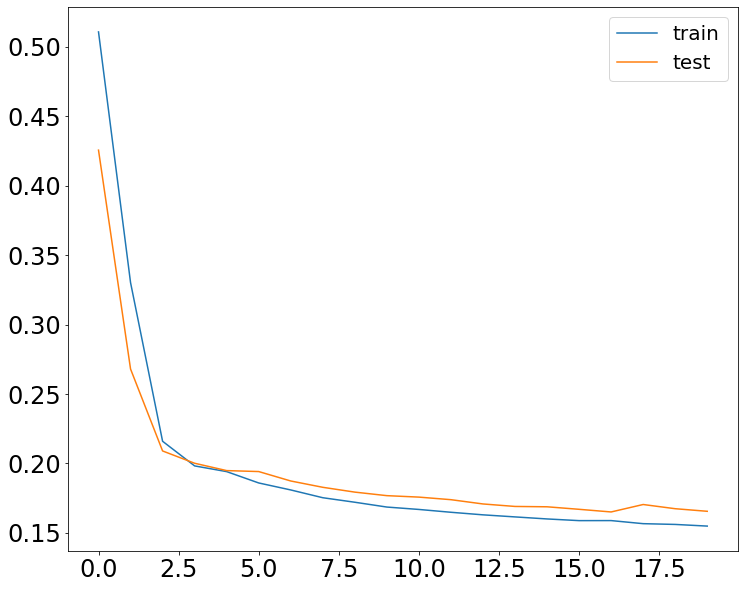

Epoch 00045: early stopping


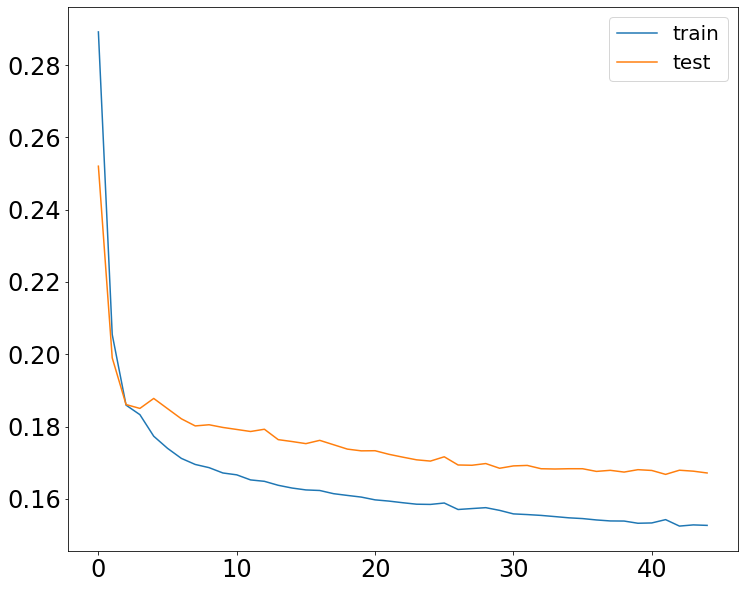

Epoch 00006: early stopping


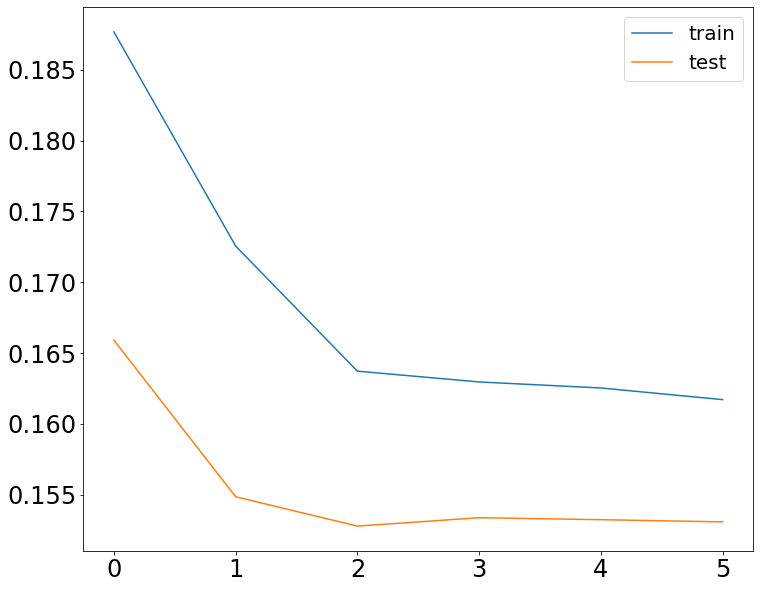

Epoch 00019: early stopping


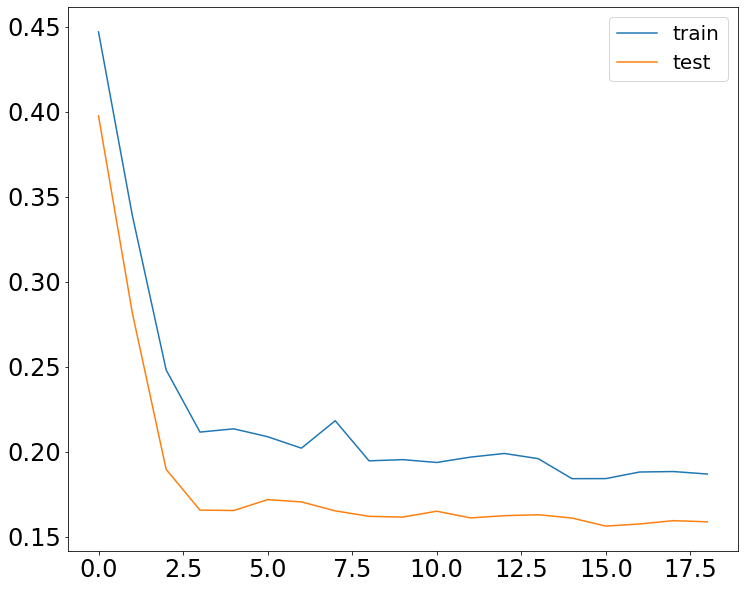

Epoch 00009: early stopping


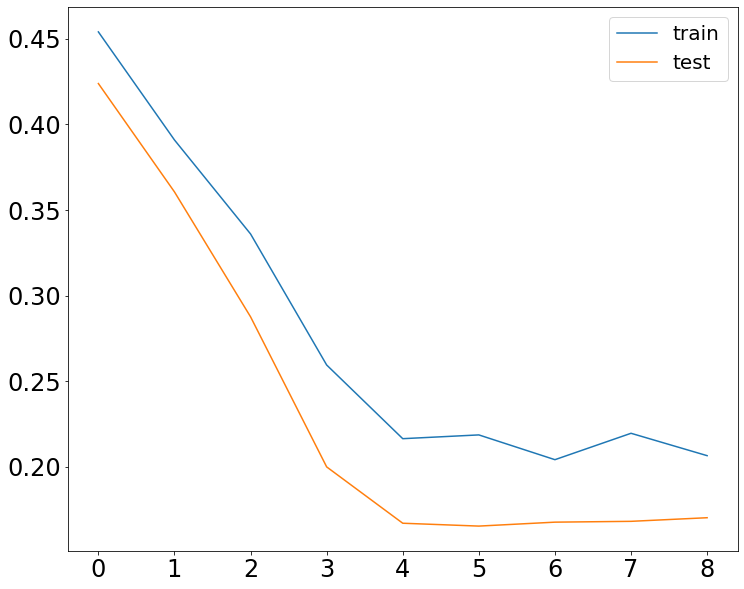

Epoch 00007: early stopping


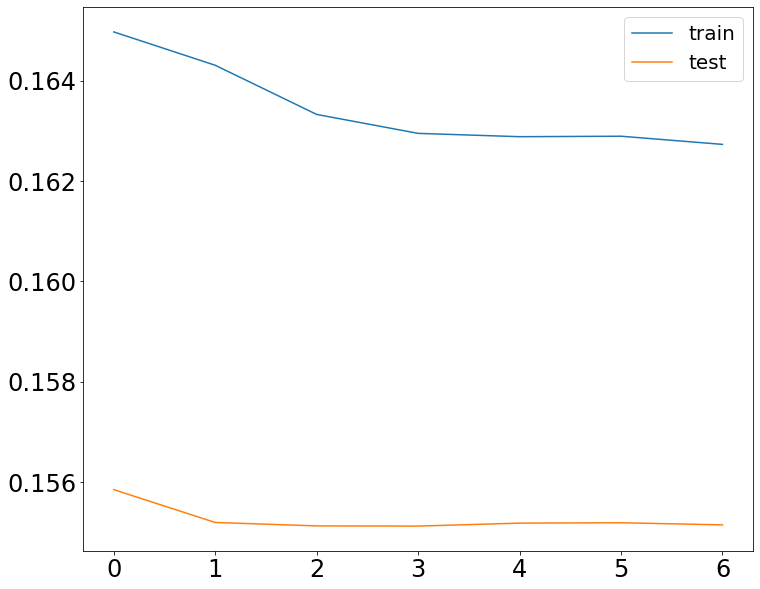

In [13]:
am = ['rl','rf','mlp_linear','mlp_relu','mlp_sigmoid','lstm_linear','lstm_relu','lstm_sigmoid']

for t in am:
    if t == 'rl':
        model = LinearRegression()
        
        #Treina o modelo
        model.fit(X_train,y_train)
        
        #Predição dos dados de teste
        y_pred = model.predict(X_test)

        y_pred_rl = sc.inverse_transform(y_pred)

        X_test_rl = sc.inverse_transform(X_test)
        y_test_rl = sc.inverse_transform(y_test)
        
        #Predição dos dados de treinamento
        y_predt = model.predict(X_train)
        y_predt_rl = sc.inverse_transform(y_predt)
        
        y_train_rl = sc.inverse_transform(y_train)
        
        '''
               
        plt.plot(y_test_rl,color='red', label='pH Observado')
        plt.plot(y_pred_rl,color='blue', label='pH predito')
        plt.xlabel('Semanas')
        plt.ylabel('Valor de pH')
        plt.legend()
        plt.title('Predição Regressão Linear')
        plt.show()
        '''
        
        mape_treino_rl       = round(mape(y_predt_rl,y_train_rl),4)
        rmse_treino_rl       = round(rmse(y_predt_rl,y_train_rl),4)
                
        mape_teste_rl        = round(mape(y_pred_rl,y_test_rl),4)
        rmse_teste_rl        = round(rmse(y_pred_rl,y_test_rl),4)
                
        r_treino_rl,r_teste_rl = df_correlacao(y_predt_rl,y_train_rl,y_pred_rl,y_test_rl)
                        
    elif t == 'rf':
        model = RandomForestRegressor()
        
        #Treina o modelo
        model.fit(X_train,y_train)

        #Predição dados de teste
        y_pred = model.predict(X_test)
                
        y_pred_rf = sc.inverse_transform(y_pred.reshape(-1, 1))
        
        X_test_rf = sc.inverse_transform(X_test)
        y_test_rf = sc.inverse_transform(y_test)
        
        #Predição dados de treinamento
        
        y_predt = model.predict(X_train)
        y_predt_rf = sc.inverse_transform(y_predt.reshape(-1, 1))
        
        y_train_rf = sc.inverse_transform(y_train)
           
        '''  
        plt.plot(y_test_rf,color='red', label='pH Observado')
        plt.plot(y_pred_rf,color='blue', label='pH predito')
        plt.xlabel('Semanas')
        plt.ylabel('Valor de pH')
        plt.legend()
        plt.title('Predição Random Forest')
        plt.show()
        '''
        
        mape_treino_rf       = round(mape(y_predt_rf,y_train_rf),4)
        rmse_treino_rf       = round(rmse(y_predt_rf,y_train_rf),4)
        
        mape_teste_rf        = round(mape(y_pred_rf,y_test_rf),4)
        rmse_teste_rf        = round(rmse(y_pred_rf,y_test_rf),4)
                
        r_treino_rf,r_teste_rf = df_correlacao(y_predt_rf,y_train_rf,y_pred_rf,y_test_rf)
        
    elif t == 'mlp_linear':
                               
        model = Sequential()
        model.add(Dense(units = 10, activation = 'relu'))
        model.add(Dense(units = 21, activation = 'relu'))
        model.add(Dense(units = 1, activation = 'linear'))
        model.compile(loss = 'mean_absolute_error', optimizer = 'adam',
                  metrics = ['mean_absolute_error'])
        
        es = EarlyStopping(monitor='val_loss', patience = 3, verbose=1)


        #Treina o modelo
        history = model.fit(X_train, y_train, validation_data=(X_test,y_test), batch_size = 32, epochs = 2000, 
                        callbacks=[es], verbose=0)

        #Treina o modelo
        #model.fit(X_train,y_train, batch_size = 32, epochs = 100)
        
        #Predição com os dados de test
        y_pred = model.predict(X_test)
        y_pred_mlp = normalizador_previsao.inverse_transform(y_pred)

        X_test_mlp = sc.inverse_transform(X_test)
        y_test_mlp = sc.inverse_transform(y_test)
        
        #Predição com os dados de treinamento
        y_predt = model.predict(X_train)
        y_predt_mlp = normalizador_previsao.inverse_transform(y_predt)
        
        y_train_mlp = sc.inverse_transform(y_train)
        
        '''
        plt.plot(y_test_mlp,color='red', label='pH Observado')
        plt.plot(y_pred_mlp,color='blue', label='pH predito')
        plt.xlabel('Semanas')
        plt.ylabel('Valor de pH')
        plt.legend()
        plt.title('Predição MLP')
        plt.show()
        '''
        
        mape_treino_mlp_linear       = round(mape(y_predt_mlp,y_train_mlp),4)
        rmse_treino_mlp_linear       = round(rmse(y_predt_mlp,y_train_mlp),4)
        
        mape_teste_mlp_linear        = round(mape(y_pred_mlp,y_test_mlp),4)
        rmse_teste_mlp_linear        = round(rmse(y_pred_mlp,y_test_mlp),4)
        
        r_treino_mlp_linear,r_teste_mlp_linear = df_correlacao(y_predt_mlp,y_train_mlp,y_pred_mlp,y_test_mlp)
        
        # plot training history
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()
        plt.show()
    
    elif t == 'mlp_relu':
                               
        model = Sequential()
        model.add(Dense(units = 10, activation = 'relu'))
        model.add(Dense(units = 21, activation = 'relu'))
        model.add(Dense(units = 1, activation = 'relu'))
        model.compile(loss = 'mean_absolute_error', optimizer = 'adam',
                  metrics = ['mean_absolute_error'])
        
        es = EarlyStopping(monitor='val_loss', patience = 3, verbose=1)


        #Treina o modelo
        history = model.fit(X_train, y_train, validation_data=(X_test,y_test), batch_size = 32, epochs = 2000, 
                        callbacks=[es], verbose=0)

        #Treina o modelo
        #model.fit(X_train,y_train, batch_size = 32, epochs = 100)
        
        #Predição com os dados de test
        y_pred = model.predict(X_test)
        y_pred_mlp = normalizador_previsao.inverse_transform(y_pred)

        X_test_mlp = sc.inverse_transform(X_test)
        y_test_mlp = sc.inverse_transform(y_test)
        
        #Predição com os dados de treinamento
        y_predt = model.predict(X_train)
        y_predt_mlp = normalizador_previsao.inverse_transform(y_predt)
        
        y_train_mlp = sc.inverse_transform(y_train)
        
        '''
        plt.plot(y_test_mlp,color='red', label='pH Observado')
        plt.plot(y_pred_mlp,color='blue', label='pH predito')
        plt.xlabel('Semanas')
        plt.ylabel('Valor de pH')
        plt.legend()
        plt.title('Predição MLP')
        plt.show()
        '''
        
        mape_treino_mlp_relu       = round(mape(y_predt_mlp,y_train_mlp),4)
        rmse_treino_mlp_relu       = round(rmse(y_predt_mlp,y_train_mlp),4)
        
        mape_teste_mlp_relu        = round(mape(y_pred_mlp,y_test_mlp),4)
        rmse_teste_mlp_relu        = round(rmse(y_pred_mlp,y_test_mlp),4)
        
        r_treino_mlp_relu,r_teste_mlp_relu = df_correlacao(y_predt_mlp,y_train_mlp,y_pred_mlp,y_test_mlp)
        
        # plot training history
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()
        plt.show()
    
    elif t == 'mlp_sigmoid':
                               
        model = Sequential()
        model.add(Dense(units = 10, activation = 'relu'))
        model.add(Dense(units = 21, activation = 'relu'))
        model.add(Dense(units = 1, activation = 'sigmoid'))
        model.compile(loss = 'mean_absolute_error', optimizer = 'adam',
                  metrics = ['mean_absolute_error'])
        
        es = EarlyStopping(monitor='val_loss', patience = 3, verbose=1)


        #Treina o modelo
        history = model.fit(X_train, y_train, validation_data=(X_test,y_test), batch_size = 32, epochs = 2000, 
                        callbacks=[es], verbose=0)

        #Treina o modelo
        #model.fit(X_train,y_train, batch_size = 32, epochs = 100)
        
        #Predição com os dados de test
        y_pred = model.predict(X_test)
        y_pred_mlp = normalizador_previsao.inverse_transform(y_pred)

        X_test_mlp = sc.inverse_transform(X_test)
        y_test_mlp = sc.inverse_transform(y_test)
        
        #Predição com os dados de treinamento
        y_predt = model.predict(X_train)
        y_predt_mlp = normalizador_previsao.inverse_transform(y_predt)
        
        y_train_mlp = sc.inverse_transform(y_train)
        
        '''
        plt.plot(y_test_mlp,color='red', label='pH Observado')
        plt.plot(y_pred_mlp,color='blue', label='pH predito')
        plt.xlabel('Semanas')
        plt.ylabel('Valor de pH')
        plt.legend()
        plt.title('Predição MLP')
        plt.show()
        '''
        
        mape_treino_mlp_sigmoid       = round(mape(y_predt_mlp,y_train_mlp),4)
        rmse_treino_mlp_sigmoid       = round(rmse(y_predt_mlp,y_train_mlp),4)
        
        mape_teste_mlp_sigmoid        = round(mape(y_pred_mlp,y_test_mlp),4)
        rmse_teste_mlp_sigmoid        = round(rmse(y_pred_mlp,y_test_mlp),4)
        
        r_treino_mlp_sigmoid,r_teste_mlp_sigmoid = df_correlacao(y_predt_mlp,y_train_mlp,y_pred_mlp,y_test_mlp)
        
        # plot training history
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()
        plt.show()
    
    elif t == 'lstm_linear':
        
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        
        model = Sequential()
        model.add(LSTM(units = 10, input_shape = (X_train.shape[1], 1)))
        model.add(Dense(10, activation = 'relu'))
        model.add(Dropout(0.2))
        model.add(Dense(1, activation = 'linear'))
        model.compile(loss = 'mean_absolute_error', optimizer = 'adam',
                  metrics = ['mean_absolute_error'])
        
        es = EarlyStopping(monitor='val_loss', patience = 3, verbose=1)


        #Treina o modelo
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size = 32, epochs = 2000, 
                        callbacks=[es], verbose=0)

        #Treina o modelo
        #model.fit(X_train,y_train, batch_size = 32, epochs = 100)

        #Predição com dados de teste
        y_pred = model.predict(X_test)
        y_pred_lstm = sc.inverse_transform(y_pred)

        y_test_lstm = sc.inverse_transform(y_test)
        y_test_lstm.shape
        
        #Predição com dados de treinamento
        y_predt = model.predict(X_train)
        y_predt_lstm = sc.inverse_transform(y_predt)

        y_train_lstm = sc.inverse_transform(y_train)
        
        '''
        plt.plot(y_test_lstm,color='red', label='pH Observado')
        plt.plot(y_pred_lstm,color='blue', label='pH predito')
        plt.xlabel('Semanas')
        plt.ylabel('Valor de pH')
        plt.legend()
        plt.title('Predição LSTM')
        plt.show()
        '''    
        
        mape_treino_lstm_linear       = round(mape(y_predt_lstm,y_train_lstm),4)
        rmse_treino_lstm_linear       = round(rmse(y_predt_lstm,y_train_lstm),4)
                
        mape_teste_lstm_linear        = round(mape(y_pred_lstm,y_test_lstm),4)
        rmse_teste_lstm_linear        = round(rmse(y_pred_lstm,y_test_lstm),4)
                
        r_treino_lstm_linear,r_teste_lstm_linear = df_correlacao(y_predt_lstm,y_train_lstm,y_pred_lstm,y_test_lstm)
        
        # plot training history
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()
        plt.show()
    
    elif t == 'lstm_relu':
        
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        
        model = Sequential()
        model.add(LSTM(units = 10, input_shape = (X_train.shape[1], 1)))
        model.add(Dense(10, activation = 'relu'))
        model.add(Dropout(0.2))
        model.add(Dense(1, activation = 'relu'))
        model.compile(loss = 'mean_absolute_error', optimizer = 'adam',
                  metrics = ['mean_absolute_error'])
        
        es = EarlyStopping(monitor='val_loss', patience = 3, verbose=1)


        #Treina o modelo
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size = 32, epochs = 2000, 
                        callbacks=[es], verbose=0)

        #Treina o modelo
        #model.fit(X_train,y_train, batch_size = 32, epochs = 100)

        #Predição com dados de teste
        y_pred = model.predict(X_test)
        y_pred_lstm = sc.inverse_transform(y_pred)

        y_test_lstm = sc.inverse_transform(y_test)
        y_test_lstm.shape
        
        #Predição com dados de treinamento
        y_predt = model.predict(X_train)
        y_predt_lstm = sc.inverse_transform(y_predt)

        y_train_lstm = sc.inverse_transform(y_train)
        
        '''
        plt.plot(y_test_lstm,color='red', label='pH Observado')
        plt.plot(y_pred_lstm,color='blue', label='pH predito')
        plt.xlabel('Semanas')
        plt.ylabel('Valor de pH')
        plt.legend()
        plt.title('Predição LSTM')
        plt.show()
        '''
        
        mape_treino_lstm_relu       = round(mape(y_predt_lstm,y_train_lstm),4)
        rmse_treino_lstm_relu       = round(rmse(y_predt_lstm,y_train_lstm),4)
                
        mape_teste_lstm_relu        = round(mape(y_pred_lstm,y_test_lstm),4)
        rmse_teste_lstm_relu        = round(rmse(y_pred_lstm,y_test_lstm),4)
                
        r_treino_lstm_relu,r_teste_lstm_relu = df_correlacao(y_predt_lstm,y_train_lstm,y_pred_lstm,y_test_lstm)
    
        # plot training history
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()
        plt.show()
    
    else:
        
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        
        model = Sequential()
        model.add(LSTM(units = 10, input_shape = (X_train.shape[1], 1)))
        model.add(Dense(10, activation = 'relu'))
        model.add(Dropout(0.2))
        model.add(Dense(1, activation = 'sigmoid'))
        model.compile(loss = 'mean_absolute_error', optimizer = 'adam',
                  metrics = ['mean_absolute_error'])

        es = EarlyStopping(monitor='val_loss', patience = 3, verbose=1)


        #Treina o modelo
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size = 32, epochs = 2000, 
                        callbacks=[es], verbose=0)

        #Predição com dados de teste
        y_pred = model.predict(X_test)
        y_pred_lstm = sc.inverse_transform(y_pred)

        y_test_lstm = sc.inverse_transform(y_test)
        y_test_lstm.shape
        
        #Predição com dados de treinamento
        y_predt = model.predict(X_train)
        y_predt_lstm = sc.inverse_transform(y_predt)

        y_train_lstm = sc.inverse_transform(y_train)
        
        '''
        plt.plot(y_test_lstm,color='red', label='pH Observado')
        plt.plot(y_pred_lstm,color='blue', label='pH predito')
        plt.xlabel('Semanas')
        plt.ylabel('Valor de pH')
        plt.legend()
        plt.title('Predição LSTM')
        plt.show()
        '''
        
        mape_treino_lstm_sigmoid       = round(mape(y_predt_lstm,y_train_lstm),4)
        rmse_treino_lstm_sigmoid       = round(rmse(y_predt_lstm,y_train_lstm),4)
                
        mape_teste_lstm_sigmoid        = round(mape(y_pred_lstm,y_test_lstm),4)
        rmse_teste_lstm_sigmoid        = round(rmse(y_pred_lstm,y_test_lstm),4)
                
        r_treino_lstm_sigmoid,r_teste_lstm_sigmoid = df_correlacao(y_predt_lstm,y_train_lstm,y_pred_lstm,y_test_lstm)
        
        # plot training history
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()
        plt.show()
        
        
# intialise data of lists.
data_treino = {'AM':['Regressão Linear','Random Forest','MLP_linear','MLP_relu','MLP_sigmoid','LSTM_linear','LSTM_relu','LSTM_sigmoid'],
        'MAPE':[mape_treino_rl, mape_treino_rf, mape_treino_mlp_linear, mape_treino_mlp_relu, mape_treino_mlp_sigmoid,mape_treino_lstm_linear,mape_treino_lstm_relu,mape_treino_lstm_sigmoid],
        'RMSE':[rmse_treino_rl, rmse_treino_rf, rmse_treino_mlp_linear, rmse_treino_mlp_relu, rmse_treino_mlp_sigmoid,rmse_treino_lstm_linear,rmse_treino_lstm_relu,rmse_treino_lstm_sigmoid],
        'R²':[r_treino_rl, r_treino_rf, r_treino_mlp_linear, r_treino_mlp_relu, r_treino_mlp_sigmoid,r_treino_lstm_linear,r_treino_lstm_relu,r_treino_lstm_sigmoid],
        'TIPO':['TREINO', 'TREINO', 'TREINO', 'TREINO','TREINO', 'TREINO', 'TREINO', 'TREINO']}

# intialise data of lists.
data_teste = {'AM':['Regressão Linear','Random Forest','MLP_linear','MLP_relu','MLP_sigmoid','LSTM_linear','LSTM_relu','LSTM_sigmoid'],
        'MAPE':[mape_teste_rl, mape_teste_rf, mape_teste_mlp_linear, mape_teste_mlp_relu, mape_teste_mlp_sigmoid,mape_teste_lstm_linear,mape_teste_lstm_relu,mape_teste_lstm_sigmoid],
        'RMSE':[rmse_teste_rl, rmse_teste_rf, rmse_teste_mlp_linear, rmse_teste_mlp_relu, rmse_teste_mlp_sigmoid,rmse_teste_lstm_linear,rmse_teste_lstm_relu,rmse_teste_lstm_sigmoid],
        'R²':[r_teste_rl, r_teste_rf, r_teste_mlp_linear, r_teste_mlp_relu, r_teste_mlp_sigmoid,r_teste_lstm_linear,r_teste_lstm_relu,r_teste_lstm_sigmoid],
        'TIPO':['TESTE', 'TESTE', 'TESTE', 'TESTE','TESTE', 'TESTE', 'TESTE', 'TESTE']}
 
# Create DataFrame
df_resultados_treino = pd.DataFrame(data_treino)
df_resultados_teste = pd.DataFrame(data_teste)
df_resultados = pd.DataFrame()
dframes = [df_resultados_treino,df_resultados_teste]
df_resultados = pd.concat(dframes)

In [14]:
df_resultados

,AM,MAPE,RMSE,R²,TIPO
0,Regressão Linear,28.5031,1.1834,0.0852,TREINO
1,Random Forest,10.3535,0.4502,0.9384,TREINO
2,MLP_linear,46.3487,2.2851,0.0644,TREINO
3,MLP_relu,46.1881,2.2838,0.0789,TREINO
4,MLP_sigmoid,44.8562,2.2708,0.0204,TREINO
5,LSTM_linear,29.5926,1.2617,0.0003,TREINO
6,LSTM_relu,29.5114,1.3284,0.0015,TREINO
7,LSTM_sigmoid,30.7998,1.2372,0.0026,TREINO
0,Regressão Linear,30.7144,1.2201,0.0217,TESTE
1,Random Forest,30.6483,1.2324,0.0407,TESTE


In [27]:
df_resultados_teste

,AM,MAPE,RMSE,R²,TIPO
0,Regressão Linear,0.3781,0.0343,0.0811,TESTE
1,Random Forest,0.3879,0.0356,0.0412,TESTE
2,MLP_linear,4.8200,0.3581,0.0889,TESTE
3,MLP_relu,4.5456,0.3494,0.0325,TESTE
4,MLP_sigmoid,4.6569,0.3398,0.0776,TESTE
5,LSTM_linear,0.3659,0.0347,0.0683,TESTE
6,LSTM_relu,0.3741,0.0356,0.0708,TESTE
7,LSTM_sigmoid,0.3878,0.0354,0.0583,TESTE
